In [1]:
from random import random, sample

In [2]:
import gensim
from node2vec import Node2Vec

C:\dev\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
import keras
import tensorflow as tf
import numpy as np

C:\dev\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
f = open('data/string_nonzero_experiments.csv')
num_links=0
for line in f:
    num_links+=1
print(num_links)

f = open('data/string_nonzero_experiments.csv')
proteins = set()
pairs = set()
uniq_pair_file = open('data/unique_string_nonzero_experiments.csv','w')
uniq_protein_file = open('data/unique_experiment_protein_ids.csv','w')

next(f)
for line in f:
    source, target, score = line.strip().split(',')
    
    if source not in proteins:
        uniq_protein_file.write(source + '\n')
    proteins.add(source)
    
    if target not in proteins:
        uniq_protein_file.write(target + '\n')
    proteins.add(target)
    
    if (source,target) not in pairs:
        uniq_pair_file.write(line)
    pairs.add((source,target))

print(len(proteins))
print(len(pairs))
uniq_pair_file.close()
uniq_protein_file.close()

f = open('data/string_nonzero_experiments.csv')
train_neg_file = open('data/protein_pairs/full_neg.dat','w')

header = next(f)
train_neg_file.write(header)

for line in f:
    negative = tuple(sample(proteins, 2))
    while negative in pairs:
        negative = tuple(sample(proteins, 2))
    train_neg_file.write(','.join(negative) + ',0\n')

train_neg_file.close()
f.close()

357945
14795
349276


In [5]:
class Sequences:
    def __init__(self, filename):
        self.filename = filename
        self.f = open(self.filename)
    
    # this function is called each epoch of gensim training
    def __iter__(self):
        self.f = open(self.filename)
        return self
    
    def __next__(self):
        line = next(self.f)
        id,sequence = line.strip().split(',')
        sequence = sequence.split(' ')
        return gensim.models.doc2vec.TaggedDocument(tags=[id], words=sequence)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [7]:
from sklearn.metrics import classification_report, precision_recall_curve, precision_score, recall_score, accuracy_score, f1_score

In [8]:
from sklearn.utils.fixes import signature
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score

In [9]:
d2v_epochs = 21
d2v_vector_size = 99
d2v_window = 8
d2v_min_count = 9
n2v_dimensions = 104
n2v_window = 6
n2v_epochs = 30
n2v_num_walks = 32
n2v_walk_length = 27
n2v_p = 4
n2v_q = 2
nn_dropout = 0.22818154872598262

In [ ]:
training_edgelist_file = 'data/protein_pairs/full.dat'

print('Training Node2Vec'.center(80,'-'))
n2v = Node2Vec()
model = n2v.fit_transform(training_edgelist_file,
                          dimensions=n2v_dimensions, 
                          window=n2v_window,
                          epochs=n2v_epochs,
                          num_walks=n2v_num_walks, 
                          walk_length=n2v_walk_length, 
                          p=n2v_p, 
                          q=n2v_q,
                         )

n2v.model.save('models/node2vec.model')

# vectorfilename = 'data/vectors/node2vec_sample{}_p{}_q{}.dat'.format(sr_str, p, q)
# vector_file = open(vectorfilename, 'w')
# for i,n in enumerate(n2v.G.nodes):
#     vector_file.write(n + ',' + ','.join([str(_) for _ in model.wv.vectors[i,:]]) + '\n')
# vector_file.close()

print('Node2Vec similarity to BRCA1'.center(80,'-'))
for v in n2v.model.wv.most_similar('P38398|BRCA1_HUMAN'):
    print(v)

#### doc2vec

filename = 'data/split_human_uniprot_sequences.dat'
sequences = Sequences(filename)
print('Training doc2vec'.center(80,'-'))

doc2vec = gensim.models.Doc2Vec(
    documents=sequences,
    epochs=d2v_epochs,
    dm=1,
    vector_size=d2v_vector_size,
    window=d2v_window,
    min_count=d2v_min_count
)

doc2vec.save('models/doc2vec.model')

print('Doc2Vec similarity to BRCA1'.center(80,'-'))
for v in doc2vec.docvecs.most_similar(positive=['P38398|BRCA1_HUMAN']):
    print(v)

unmatched_doc2vec_node2vec_proteins_file = open('data/unmatched_doc2vec_node2vec_proteins_file.csv','w')
i=0

In [20]:
vectors = dict()
for protein in n2v.model.wv.index2word:
#     print(protein)
    try:
        v = np.append(
            doc2vec[protein],
            n2v.model.wv[protein]
        )
        vectors[protein] = v
        i+=1
    except:
        unmatched_doc2vec_node2vec_proteins_file.write(protein + '\n')

unmatched_doc2vec_node2vec_proteins_file.close()
#     print(i)

AttributeError: 'Word2Vec' object has no attribute 'model'

In [19]:
print('Generating Training and validation datasets'.center(80,'-'))

train_file = open('data/protein_pairs/full.dat')
header = next(train_file)
x_train = []
y_train = []

for line in train_file:
    source, target, score = line.strip().split(',')
    if source in vectors and target in vectors:
        vs = vectors[source]
        vt = vectors[target]
        x_train.append(np.append(vs,vt))
        y_train.append(np.array([1]))

train_neg_file = open('data/protein_pairs/full_neg.dat')
header = next(train_neg_file)

for line in train_neg_file:
    source, target, score = line.strip().split(',')
    if source in vectors and target in vectors:
        vs = vectors[source]
        vt = vectors[target]
        x_train.append(np.append(vs,vt))
        y_train.append(np.array([0]))

x_train = np.array(x_train)
y_train = np.array(y_train)

print('Training data shape')
print('x',x_train.shape)
print('y',y_train.shape)

------------------Generating Training and validation datasets-------------------


NameError: name 'vectors' is not defined

In [13]:
print('Training Neural Network'.center(80,'-'))

model = Sequential()

input_size = (d2v_vector_size + n2v_dimensions)*2

model.add(Dense(units=256, activation='relu', input_dim=input_size))
model.add(Dropout(nn_dropout))
model.add(Dense(units=128, activation='relu', input_dim=256))
model.add(Dropout(nn_dropout))
model.add(Dense(units=64, activation='relu', input_dim=128))
model.add(Dropout(nn_dropout))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])

# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
model.fit(x_train, y_train, epochs=10, batch_size=32)

----------------------------Training Neural Network-----------------------------
Epoch 1/10
685527/685527 [==============================] - 96s 140us/step - loss: 0.3300 - binary_accuracy: 0.8567
Epoch 2/10
685527/685527 [==============================] - 95s 139us/step - loss: 0.2025 - binary_accuracy: 0.9228
Epoch 3/10
685527/685527 [==============================] - 96s 141us/step - loss: 0.1776 - binary_accuracy: 0.9352
Epoch 4/10
685527/685527 [==============================] - 95s 138us/step - loss: 0.1665 - binary_accuracy: 0.9409
Epoch 5/10
685527/685527 [==============================] - 95s 138us/step - loss: 0.1612 - binary_accuracy: 0.9446
Epoch 6/10
685527/685527 [==============================] - 94s 137us/step - loss: 0.1594 - binary_accuracy: 0.94802s - loss:
Epoch 7/10
685527/685527 [==============================] - 94s 137us/step - loss: 0.1646 - binary_accuracy: 0.9510
Epoch 8/10
685527/685527 [==============================] - 92s 134us/step - loss: 0.1657 - binar

### Finding New Interactions

##### Non symmetric nature of predictions

In [344]:
v = np.concatenate([
    vectors['P50553|ASCL1_HUMAN'],
    vectors['P41134|ID1_HUMAN']
])

v = np.array([v])
print("Mash to ID1")
print(model.predict_proba(x=v, batch_size=1)[0][0])

v = np.concatenate([
    vectors['P41134|ID1_HUMAN'],
    vectors['P50553|ASCL1_HUMAN']
])

v = np.array([v])
print("ID1 to Mash")
print(model.predict_proba(x=v, batch_size=1)[0][0])

Mash to ID1
0.9312986
ID1 to Mash
0.5803551


In [345]:
def find_new_interactions(target_protein, threshold=.9):
    probs = []

    for protein,vector in vectors.items():
        x = np.concatenate([
            vector, vectors[target_protein]
        ])
        x = np.array([x])
        y_prob = model.predict_proba(x, batch_size=1)[0][0]
        probs.append((protein, y_prob))

    predicted_interactors = set([protein for protein,prob in probs if prob > threshold])

    # sorted(high_probs, key=lambda protein_prob: protein_prob[1], reverse=True)
    # for protein, prob in filter(probs[:10]:
    #     print(protein, prob[0][0])

    with open('data/protein_pairs/full.csv') as f:
        known_interactors = set()

        header = next(f)

        for line in f:
            source, target, score = line.strip().split(',')
            if target == target_protein or source == target_protein:
                known_interactors.add(source)

    new_interactors = predicted_interactors - known_interactors
    return new_interactors

In [346]:
# return set(sorted(new_interactors, key = lambda _: _.split('|')[1]))

In [347]:
new_bmp2_interactors = find_new_interactions('P12643|BMP2_HUMAN', threshold=.95)
new_mash_interactors = find_new_interactions('P50553|ASCL1_HUMAN', threshold=.95)
new_id1_interactors = find_new_interactions('P41134|ID1_HUMAN', threshold=.95)
new_ngn_interactors = find_new_interactions('Q9H2A3|NGN2_HUMAN', threshold=.95)
new_hes1_interactors = find_new_interactions('Q14469|HES1_HUMAN', threshold=.95)

In [348]:
print('bmp2: {}'.format(len(new_bmp2_interactors)))
print('mash: {}'.format(len(new_mash_interactors)))
print('id1: {}'.format(len(new_id1_interactors)))
print('ngn: {}'.format(len(new_ngn_interactors)))
print('hes1: {}'.format(len(new_hes1_interactors)))

bmp2: 61
mash: 102
id1: 510
ngn: 113
hes1: 534


In [349]:
new_affects_all = (
    new_bmp2_interactors & 
    new_hes1_interactors & 
    new_id1_interactors & 
    new_mash_interactors &
    new_ngn_interactors
)

for protein in new_affects_all:
    print(protein)

P21333|FLNA_HUMAN
P43121|MUC18_HUMAN
Q99973|TEP1_HUMAN
O14746|TERT_HUMAN
Q09666|AHNK_HUMAN
Q15797|SMAD1_HUMAN
Q13485|SMAD4_HUMAN
P84022|SMAD3_HUMAN


In [363]:
def print_predictions(protein, predictions):
    with open('data/predicted_interactions_'+protein,'w') as prediction_file:
        for prediction in predictions: 
            prediction = prediction.split('|')[1]
            prediction = prediction.split('_')[0]
            prediction_file.write(prediction+'\n')

In [364]:
affects_only_bmp2 = (
    new_bmp2_interactors -
    (new_hes1_interactors |
    new_id1_interactors |
    new_mash_interactors |
    new_ngn_interactors)
)
print(len(affects_only_bmp2))
print_predictions('bmp2', affects_only_bmp2)

33


In [365]:
affects_only_mash = (
    new_mash_interactors - 
    (new_bmp2_interactors |
    new_hes1_interactors |
    new_id1_interactors |
    new_ngn_interactors)
)
print(len(affects_only_mash))
print_predictions('mash', affects_only_mash)

13


In [366]:
affects_only_id1 = (
    new_id1_interactors- 
    (new_bmp2_interactors |
    new_hes1_interactors |
    new_mash_interactors |
    new_ngn_interactors)
)
print(len(affects_only_id1))
print_predictions('id1', affects_only_id1)

245


In [367]:
affects_only_hes1 = (
    new_hes1_interactors - 
    (new_bmp2_interactors |
    new_id1_interactors |
    new_mash_interactors |
    new_ngn_interactors)
)
print(len(affects_only_hes1))
print_predictions('hes1', affects_only_hes1)

274


In [368]:
affects_only_ngn = (
    new_ngn_interactors - 
    (new_bmp2_interactors |
    new_hes1_interactors |
    new_mash_interactors |
    new_id1_interactors)
)
print(len(affects_only_ngn))
print_predictions('ngn', affects_only_ngn)

17


### Graph Cluster Analysis

In [189]:
import json

In [190]:
from collections import Counter

In [305]:
clusters = {}
with open('gephi/clustered.csv') as f:
    header = next(f)
    for line in f:
        protein,_,_,cluster = line.strip().split(',')
        cluster = int(cluster)
        if cluster not in clusters: clusters[cluster]=[]
        clusters[cluster].append(protein)   

In [234]:
clusters.keys()

dict_keys([25, 2, 10, 13, 1, 5, 19, 12, 6, 15, 7, 14, 8, 3, 17, 0, 4, 21, 20, 9, 11, 18, 16, 26, 22, 23, 24, 27, 37, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38])

In [235]:
cluster_sizes = {}
# threshold = 100
for c,x in clusters.items():
    cluster_sizes[c] = len(x)
print(cluster_sizes)

{25: 675, 2: 1513, 10: 1272, 13: 737, 1: 1818, 5: 269, 19: 753, 12: 672, 6: 544, 15: 899, 7: 771, 14: 194, 8: 127, 3: 1613, 17: 303, 0: 1051, 4: 543, 21: 290, 20: 185, 9: 205, 11: 262, 18: 62, 16: 2, 26: 3, 22: 2, 23: 2, 24: 4, 27: 2, 37: 4, 28: 2, 29: 2, 30: 2, 31: 2, 32: 1, 33: 2, 34: 1, 35: 2, 36: 2, 38: 2}


In [306]:
def cluster_enrichment_analysis(clusters):
    subcellular_locations = json.load(open('data/subcellular_locations.json'))

    locations_in_cluster = {}
    for cluster,proteins in clusters.items():
        for protein in proteins:
            if protein in subcellular_locations:
                locations = subcellular_locations[protein]
                if cluster not in locations_in_cluster: locations_in_cluster[cluster] = Counter()
                for location in locations:
                    locations_in_cluster[cluster][location] += 1

    location_totals = Counter()
    for gene,locations in subcellular_locations.items():
        for location in locations:
            location_totals[location] += 1

    cluster_totals = {}
    locations_sum = 0
    for cluster,locations in locations_in_cluster.items():
        total = sum([count for location, count in locations.items()])
        cluster_totals[cluster] = total
#         print('{:2} {:4}'.format(cluster, total))
        locations_sum += total

    print("Count of all location associations")
    print(locations_sum)
    print('-'*80)

    sorted_location_totals = sorted(
        location_totals.items(), 
        key=lambda kv: kv[1])

#     for location, count in sorted_location_totals:
#         print('{:61} {}'.format(location, count))

    import scipy

    num_tests = 0
    for cluster, locations in locations_in_cluster.items():
        for location, count in locations.items():
            num_tests+=1
    print('Number of statistical tests conducted')
    print(num_tests)
    adjusted_significance_threshold = .05/num_tests
    print('-'*80)
    print('Bonferroni adjusted significance threshold')
    print(adjusted_significance_threshold)
    print('-'*80)

    p_values = []
    for cluster, locations in locations_in_cluster.items():
        for location, count in locations.items():
            location_total = location_totals[location]
            cluster_total = cluster_totals[cluster]
            proportion_in_cluster = float(count)/location_total
            hpd = scipy.stats.hypergeom(M=locations_sum, # population size
                                        n=location_total, # total "successes"
                                        N=cluster_total # number of "tries"
                                       )
            p = hpd.sf(count)
            d = (
                cluster, 
                location, 
                count, 
                location_total,
                cluster_total,
                proportion_in_cluster, 
                p
            )
            s = '{:2} {:<63} {:<4} {:<5} {:<5} {:<.4f} {:<.8f}'.format(*d)
            p_values.append(d)
#             print(s)

    sorted_p_values = sorted(p_values, key=lambda d: d[6])
    significant_p_values = [d for d in sorted_p_values 
                            if d[6] < adjusted_significance_threshold and d[2] > 10]
    print('Number of significant enrichments')
    print(len(significant_p_values))

    return significant_p_values

In [327]:
def print_interesting_enrichments(clusters, interesting_cluster_id):
    interesting_cluster_enrichments = []

    for d in significant_p_values:
        if d[0] == interesting_cluster_id:
            interesting_cluster_enrichments.append(d[1])

    enriched_proteins = set()
    for protein in clusters[interesting_cluster]:
        if protein in subcellular_locations:
            subcellular_location = subcellular_locations[protein]
            for location in subcellular_location:
                if location in interesting_cluster_enrichments:
                    enriched_proteins.add(protein)
                    break
    
    for protein in sorted(enriched_proteins, key=lambda _: _.split('|')[1]):
        print('{} {}'.format(protein, subcellular_locations[protein]))

In [328]:
def print_cluster(clusters, cluster_id):
    for protein in clusters[cluster_id]:
        if protein in subcellular_locations:
            locations = subcellular_locations[protein]
        else:
            locations = []
    
        print('{} {}'.format(protein, locations))

In [307]:
def print_p_values(significant_p_values, sort_by='p'):
    header = ['cluster','location','count','location_total','cluster_total','proportion_in_cluster','p']
    print('{:8} {:30} {:<6} {:<15} {:<15} {:<21} {:<8}'.format(*header))

    if sort_by == 'cluster':
        significant_p_values = sorted(significant_p_values, key=lambda _: _[0])
    if sort_by == 'p':
        significant_p_values = sorted(significant_p_values, key=lambda _: _[6])
    
    for d in significant_p_values:
        count = d[2]
        print('{:8} {:<30} {:<6} {:<15} {:<15} {:<21.4f} {:<.8f}'.format(*d))

In [308]:
significant_p_values = cluster_enrichment_analysis(clusters)

Count of all location associations
35956
--------------------------------------------------------------------------------
Number of statistical tests conducted
2068
--------------------------------------------------------------------------------
Bonferroni adjusted significance threshold
2.4177949709864606e-05
--------------------------------------------------------------------------------
Number of significant enrichments
104


In [309]:
print_p_values(significant_p_values, sort_by='cluster')

cluster  location                       count  location_total  cluster_total   proportion_in_cluster p       
       0 cell junction                  171    828             3070            0.2065                0.00000000
       0 synapse                        108    450             3070            0.2400                0.00000000
       0 postsynaptic cell membrane     63     210             3070            0.3000                0.00000000
       0 multi-pass membrane protein    395    3277            3070            0.1205                0.00000000
       0 cell membrane                  385    3339            3070            0.1153                0.00000000
       0 postsynaptic density           28     92              3070            0.3043                0.00000000
       0 tight junction                 24     97              3070            0.2474                0.00000040
       0 sarcolemma                     16     51              3070            0.3137                0.000

In [311]:
enriched_clusters = set()
for d in significant_p_values:
    enriched_clusters.add(d[0])
len(enriched_clusters)

20

In [331]:
interesting_cluster = 7
outfile = open('data/graph_cluster_7.dat','w')
for protein in sorted(clusters[interesting_cluster], key=lambda _: _.split('|')[1]):
    if protein in subcellular_locations:
            locations = subcellular_locations[protein]
    else:
        locations = []

    outfile.write('{} {}'.format(protein, locations) + '\n')
outfile.close()

In [332]:
print_interesting_enrichments(clusters=clusters,interesting_cluster_id=7)

P02763|A1AG1_HUMAN ['secreted']
P01009|A1AT_HUMAN ['secreted', 'endoplasmic reticulum']
P04217|A1BG_HUMAN ['secreted']
P08697|A2AP_HUMAN ['secreted']
P01023|A2MG_HUMAN ['secreted']
P01011|AACT_HUMAN ['secreted']
P22303|ACES_HUMAN ['cell junction', 'synapse', 'secreted', 'cell membrane', 'peripheral membrane protein', 'nucleus']
O00468|AGRIN_HUMAN ['secreted', 'extracellular space', 'extracellular matrix']
P02768|ALBU_HUMAN ['secreted']
Q9NP70|AMBN_HUMAN ['secreted', 'extracellular space', 'extracellular matrix']
P02760|AMBP_HUMAN ['secreted']
Q6UX39|AMTN_HUMAN ['secreted']
P01019|ANGT_HUMAN ['secreted']
P01008|ANT3_HUMAN ['secreted', 'extracellular space']
P02647|APOA1_HUMAN ['secreted']
P02652|APOA2_HUMAN ['secreted']
P06727|APOA4_HUMAN ['secreted']
Q6Q788|APOA5_HUMAN ['secreted']
P04114|APOB_HUMAN ['cytoplasm', 'secreted']
P02654|APOC1_HUMAN ['secreted']
P02655|APOC2_HUMAN ['secreted']
P02656|APOC3_HUMAN ['secreted']
P05090|APOD_HUMAN ['secreted']
P02649|APOE_HUMAN ['secreted']
Q1379

### Vector Clustering Analysis

In [153]:
from umap import UMAP

In [154]:
from sklearn.manifold import TSNE

In [155]:
from sklearn.cluster import DBSCAN

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline

In [160]:
vectorsl = np.array(list(vectors.values()))

In [161]:
vectorsl.shape

(14434, 203)

In [162]:
umap = UMAP(metric='cosine', min_dist=0, n_neighbors=5)

In [157]:
len(vectors['P52952|NKX25_HUMAN'])

203

In [163]:
reduced = umap.fit_transform(vectorsl)

In [165]:
# find the outliers
print(sorted(reduced[:,0])[:10])
print(sorted(reduced[:,0])[-10:])
print(sorted(reduced[:,1])[:10])
print(sorted(reduced[:,1])[-10:])

[-4.0252542, -4.025214, -4.023051, -4.021282, -4.019317, -3.9467309, -3.7126315, -3.710527, -3.7079403, -3.707926]
[6.6857066, 6.7196507, 6.7198324, 6.7253113, 6.726848, 11.950672, 11.950928, 11.951028, 11.951163, 11.951344]
[-9.281419, -9.281256, -9.281223, -9.281085, -7.563748, -7.5636764, -7.563512, -7.563347, -7.5633035, -7.5569973]
[7.25744, 7.258804, 11.194049, 11.199344, 11.20154, 11.201544, 11.201567, 11.201812, 11.202355, 11.204451]


In [119]:
from matplotlib.pyplot import figure

In [151]:
# dbscan = DBSCAN(min_samples=200)
# clustered = dbscan.fit_predict(reduced)
# figure(figsize=(8,8))
# plt.scatter(
#     reduced[:,0],
#     reduced[:,1],
#     marker = '.',
#     c = clustered,
#     s = 1
# )
# #plt.rcParams["figure.figsize"] = (4,4)
# plt.xlim([-7.5,7.5])
# plt.ylim([-7.5,7.5])

In [167]:
from matplotlib.pyplot import figure

In [256]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets

clustering_scores = []
for num_clusters in range(5,15):
    aggclust = AgglomerativeClustering(linkage='ward', n_clusters=num_clusters)
    clustered = aggclust.fit_predict(reduced)
    m = metrics.calinski_harabaz_score(reduced, clustered)
    clustering_scores.append(m)

In [258]:
for i,score in enumerate(clustering_scores):
    print('n_clusters: ', i+5, ' score:', score)

n_clusters:  5  score: 10981.178378727458
n_clusters:  6  score: 11358.737057653068
n_clusters:  7  score: 12332.478164064796
n_clusters:  8  score: 13286.236659843707
n_clusters:  9  score: 13671.740947351718
n_clusters:  10  score: 14305.861495915964
n_clusters:  11  score: 13979.407353773264
n_clusters:  12  score: 13721.98816175828
n_clusters:  13  score: 13587.307746059536
n_clusters:  14  score: 13425.120601105205


In [333]:
best_num_clusters = 10

In [334]:
aggclust = AgglomerativeClustering(linkage='ward', n_clusters=best_num_clusters)
clustered = aggclust.fit_predict(reduced)

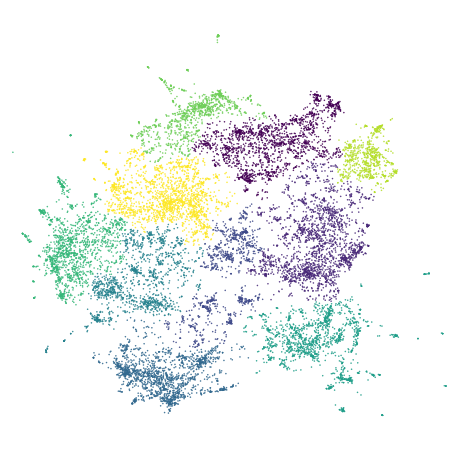

In [335]:
figure(figsize=(8,8))
plt.scatter(
    reduced[:,0],
    reduced[:,1],
    marker = '.',
    c = clustered,
    s = 1
)
plt.xlim([-4,7])
plt.ylim([-5,8])
plt.tick_params(axis='both', 
                which='both', 
                bottom=False, 
                top=False, 
                labelbottom=False, right=False, left=False, labelleft=False)
plt.box(False)

In [336]:
cluster_counts = Counter()
for _ in clustered:
    cluster_counts[_] += 1

In [337]:
print(set(clustered))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [338]:
proteins = list(vectors.keys())
clusters = {}
for i,protein in enumerate(proteins):
    cluster = clustered[i]
    if cluster not in clusters: clusters[cluster] = []
    clusters[cluster].append(protein)
print(len(clusters))

10


In [339]:
significant_p_values = cluster_enrichment_analysis(clusters)

Count of all location associations
35956
--------------------------------------------------------------------------------
Number of statistical tests conducted
1253
--------------------------------------------------------------------------------
Bonferroni adjusted significance threshold
3.990422984836393e-05
--------------------------------------------------------------------------------
Number of significant enrichments
54


In [340]:
print_p_values(significant_p_values, sort_by='cluster')

cluster  location                       count  location_total  cluster_total   proportion_in_cluster p       
       0 nucleus                        1008   5430            4162            0.1856                0.00000000
       0 nucleus speckle                63     182             4162            0.3462                0.00000000
       0 chromosome                     87     466             4162            0.1867                0.00000254
       0 nucleoplasm                    41     178             4162            0.2303                0.00000485
       0 nucleolus                      75     393             4162            0.1908                0.00000489
       1 nucleus                        773    5430            4378            0.1424                0.00000034
       3 multi-pass membrane protein    1330   3277            4804            0.4059                0.00000000
       3 endoplasmic reticulum membrane 215    778             4804            0.2763                0.000

In [341]:
len(clusters[0])

1782

In [343]:
interesting_cluster = 0
outfile = open('data/families/vector_cluster_0.dat','w')
for protein in sorted(clusters[interesting_cluster], key=lambda _: _.split('|')[1]):
    if protein in subcellular_locations:
            locations = subcellular_locations[protein]
    else:
        locations = []

    outfile.write('{} {}'.format(protein, locations) + '\n')
outfile.close()

In [342]:
print_interesting_enrichments(clusters=clusters, interesting_cluster_id=0)

P54646|AAPK2_HUMAN ['cytoplasm', 'nucleus']
Q9NY61|AATF_HUMAN ['nucleus', 'nucleolus']
O43707|ACTN4_HUMAN ['nucleus', 'cytoplasm', 'cell junction', 'cytoplasm', 'cytoskeleton', 'stress fiber']
Q9NZN9|AIPL1_HUMAN ['cytoplasm', 'nucleus']
Q15327|ANKR1_HUMAN ['nucleus']
Q9NQW6|ANLN_HUMAN ['nucleus', 'cytoplasm', 'cytoskeleton', 'cytoplasm', 'cell cortex', 'cell projection']
Q6UB99|ANR11_HUMAN ['nucleus']
Q86SG2|ANR23_HUMAN ['nucleus']
O15084|ANR28_HUMAN ['nucleus', 'nucleoplasm']
Q8WVL7|ANR49_HUMAN ['nucleus']
Q9BS18|APC13_HUMAN ['nucleus']
Q9H9F9|ARP5_HUMAN ['nucleus', 'cytoplasm']
Q96QE3|ATAD5_HUMAN ['nucleus']
Q8WXE1|ATRIP_HUMAN ['nucleus']
Q9H3M9|ATX3L_HUMAN ['nucleus']
Q99933|BAG1_HUMAN ['nucleus', 'cytoplasm']
O95817|BAG3_HUMAN ['nucleus', 'cytoplasm']
Q9P287|BCCIP_HUMAN ['nucleus', 'cytoplasm', 'cytoskeleton', 'microtubule organizing center', 'centrosome', 'centriole', 'cytoplasm', 'cytoskeleton', 'spindle pole']
Q9BXY8|BEX2_HUMAN ['cytoplasm', 'nucleus']
Q00994|BEX3_HUMAN ['nucleu

In [325]:
print_cluster(clusters, 7)

P08908|5HT1A_HUMAN ['cell membrane', 'multi-pass membrane protein']
P28222|5HT1B_HUMAN ['cell membrane', 'multi-pass membrane protein']
P28221|5HT1D_HUMAN ['cell membrane', 'multi-pass membrane protein']
P28223|5HT2A_HUMAN ['cell membrane', 'multi-pass membrane protein', 'cell projection', 'dendrite', 'cell projection', 'axon', 'cytoplasmic vesicle', 'membrane', 'caveola']
P41595|5HT2B_HUMAN ['cell membrane', 'multi-pass membrane protein', 'cell junction', 'synapse', 'synaptosome']
P28335|5HT2C_HUMAN ['cell membrane', 'multi-pass membrane protein']
P34969|5HT7R_HUMAN ['cell membrane', 'multi-pass membrane protein']
P30542|AA1R_HUMAN ['cell membrane', 'multi-pass membrane protein']
P29274|AA2AR_HUMAN ['cell membrane', 'multi-pass membrane protein']
Q13685|AAMP_HUMAN ['cell membrane', 'cytoplasm']
O95477|ABCA1_HUMAN ['membrane', 'multi-pass membrane protein']
Q86UK0|ABCAC_HUMAN ['membrane', 'multi-pass membrane protein']
Q9BYF1|ACE2_HUMAN ['cell membrane', 'single-pass type i membrane pr

In [312]:
def is_interesting(x, interesting_cluster):
    if x==interesting_cluster:
        return 'red'
    else:
        return 'grey'

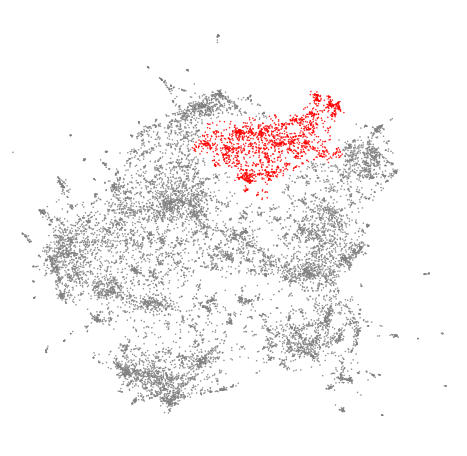

In [317]:
figure(figsize=(8,8))
plt.scatter(
    reduced[:,0],
    reduced[:,1],
    marker = '.',
    c = [is_interesting(x, interesting_cluster) for x in clustered],
    s = 1
)
plt.xlim([-4,7])
plt.ylim([-5,8])
plt.tick_params(axis='both', which='both', bottom=False, 
                top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.box(False)

In [ ]:
tsne = TSNE(perplexity=40)

samples = vectorsl[np.random.choice(vectorsl.shape[0], 500, replace=False), :]
tsne_reduced = tsne.fit_transform(vectorsl)

In [ ]:
dbscan = DBSCAN()
clustered = dbscan.fit_predict(vectorsl)

plt.scatter(
    tsne_reduced[:,0],
    tsne_reduced[:,1],
    marker = '.',
    c = clustered,
    s = 1
)

In [ ]:
tsne = TSNE(perplexity=60)

tsne_reduced = tsne.fit_transform(vectorsl)

dbscan = DBSCAN()
clustered = dbscan.fit_predict(vectorsl)

plt.scatter(
    tsne_reduced[:,0],
    tsne_reduced[:,1],
    marker = '.',
    c = clustered,
    s = 1
)

In [ ]:
tsne = TSNE(perplexity=80)

tsne_reduced = tsne.fit_transform(vectorsl)

dbscan = DBSCAN()
clustered = dbscan.fit_predict(vectorsl)

plt.scatter(
    tsne_reduced[:,0],
    tsne_reduced[:,1],
    marker = '.',
    c = clustered,
    s = 1
)

In [ ]:
tsne = TSNE(perplexity=120)

tsne_reduced = tsne.fit_transform(vectorsl)

dbscan = DBSCAN()
clustered = dbscan.fit_predict(vectorsl)

plt.scatter(
    tsne_reduced[:,0],
    tsne_reduced[:,1],
    marker = '.',
    c = clustered,
    s = 1
)

#### Weight analysis

In [140]:
import seaborn as sns

In [135]:
weights = model.get_weights()

In [179]:
for _ in weights:
    print(_.shape)

(406, 256)
(256,)
(256, 128)
(128,)
(128, 64)
(64,)
(64, 1)
(1,)


In [153]:
weights[0].min()

-6.5713873

In [154]:
weights[0].max()

7.303444

In [164]:
print(d2v_vector_size, n2v_dimensions)

99 104


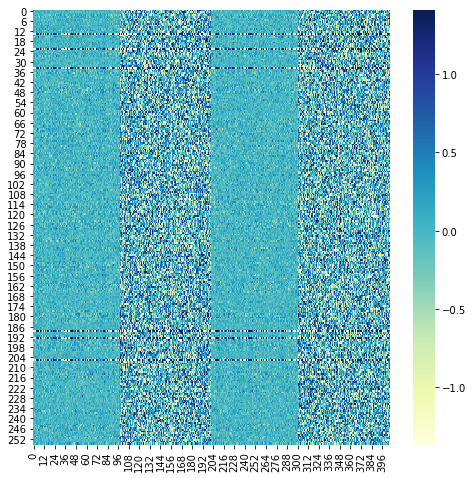

In [183]:
figure(figsize=(8,8))
sns.heatmap(weights[0].T, cmap="YlGnBu", robust=True)

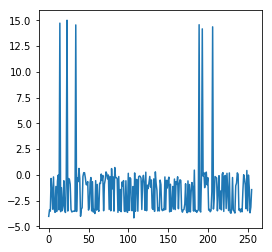

In [184]:
plt.plot(weights[1])

In [175]:
print(weights[0][0:d2v_vector_size].var())
print(weights[0][0:d2v_vector_size].mean())

0.08970182
0.006168337


In [177]:
print(weights[0][d2v_vector_size:d2v_vector_size+n2v_dimensions].var())
print(weights[0][d2v_vector_size:d2v_vector_size+n2v_dimensions].mean())

0.71420676
0.00018492584


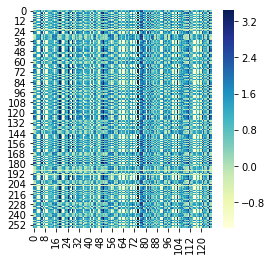

In [180]:
sns.heatmap(weights[2], cmap="YlGnBu", robust=True)

In [187]:
print(n2v_dimensions + d2v_vector_size + d2v_vector_size + n2v_dimensions)

406


#### Model Loading/saving

In [194]:
n2v.model.save('models/n2v_full_data.model')

In [195]:
doc2vec.save('models/d2v_full_data.model')

In [196]:
model.save('models/nn_full_data.model')

In [37]:
from gensim.models import Doc2Vec
from node2vec import Node2Vec
import keras
import numpy as np

In [18]:
# d2v = gensim.models.Doc2Vec()
doc2vec = gensim.models.Doc2Vec.load('models/d2v_full_data.model')
n2v = gensim.models.Word2Vec.load('models/n2v_full_data.model')
model = keras.models.load_model('models/nn_full_data.model')

In [42]:
vectors = dict()
i=0
for protein in n2v.wv.index2word:
#     print(protein)
    try:
        v = np.append(
            doc2vec[protein],
            n2v.wv[protein]
        )
        vectors[protein] = v
    except:
        pass

In [43]:
len(vectors)

14434